# AlanineDipeptide

# 1. Training & Loading

In [1]:
import numpy as np
import torch
from torch import nn
import flow
import train
import utils
import math
import h5py

# Set gobal variables.

rootFolder = "./demo/Model_CC(=O)NC(C)C(=O)NC_Batch_200_T_300_depthLevel_1_l8_M2_H128/"
device = torch.device("cpu")
dtype = torch.float32
smile = "CC(=O)NC(C)C(=O)NC"
dataset = "./database/alanine-dipeptide-3x250ns-heavy-atom-positions.npz"

# Load paremeters

with h5py.File(rootFolder+"/parameter.hdf5","r") as f:
    n = int(np.array(f["n"]))
    numFlow = int(np.array(f["numFlow"]))
    lossPlotStep = int(np.array(f["lossPlotStep"]))
    hidden = int(np.array(f["hidden"]))
    nlayers = int(np.array(f["nlayers"]))
    nmlp = int(np.array(f["nmlp"]))
    lr = int(np.array(f["lr"]))
    batchSize = int(np.array(f["batchSize"]))
    Nepochs = int(np.array(f["Nepochs"]))
    K = int(np.array(f["K"]))
    fix = np.array(f["fix"])
    scaling = float(np.array(f["scaling"]))
    
# Rebuild the model.

def innerBuilder(num):
    maskList = []
    for i in range(nlayers):
        if i %2==0:
            b = torch.zeros(num)
            i = torch.randperm(b.numel()).narrow(0, 0, b.numel() // 2)
            b.zero_()[i] = 1
            b=b.reshape(1,num)
        else:
            b = 1-b
        maskList.append(b)
    maskList = torch.cat(maskList,0).to(torch.float32)
    fl = flow.RNVP(maskList, [utils.SimpleMLPreshape([num]+[hidden]*nmlp+[num],[nn.Softplus()]*nmlp+[None]) for _ in range(nlayers)], [utils.SimpleMLPreshape([num]+[hidden]*nmlp+[num],[nn.Softplus()]*nmlp+[utils.ScalableTanh(num)]) for _ in range(nlayers)])
    return fl

from utils import flowBuilder

f = flowBuilder(n,numFlow,innerBuilder,1).to(device).to(dtype)

# Load saving.

import os
import glob
name = max(glob.iglob(rootFolder+"savings/"+'*.saving'), key=os.path.getctime)
print("load saving at "+name)
saved = torch.load(name,map_location=device)
f.load(saved);

/Users/lili/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


load saving at ./demo/Model_CC(=O)NC(C)C(=O)NC_Batch_200_T_300_depthLevel_1_l8_M2_H128/savings/FlowNetSaving_epoch490.saving


# 2. Analysis


/Users/lili/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


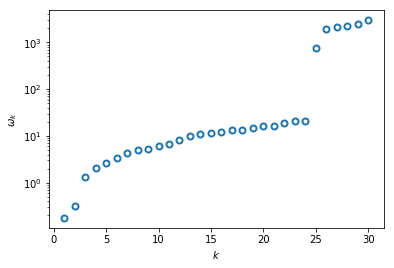

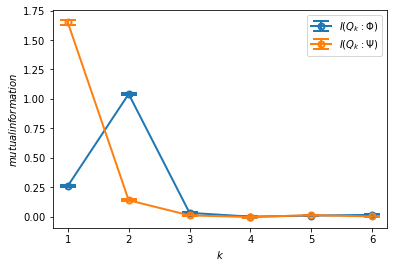

In [2]:
# Calculate modes in the latent space.

d0 = f.layerList[0].elements[:n]
d1 = f.layerList[0].elements[n:]
omega = (1/(torch.exp(d0+d1))).detach()

omega, idx = torch.sort(omega)

from matplotlib import pyplot as plt

klist = np.arange(len(omega)) +1
plt.figure()
plt.plot(klist, omega.detach().cpu().numpy(), 'o',  markerfacecolor='none', markeredgewidth=2)
plt.xlabel('$k$')
plt.ylabel('$\omega_k$')
plt.yscale('log')
plt.legend(loc='lower right')

from thirdparty import kraskov_mi

Nsamples = 5
Npersample = 1000
loadrange = ['arr_0','arr_1','arr_2']

from utils import loadmd, variance, smile2mass
SMILE = smile2mass(smile)
pVariance = torch.tensor([variance(torch.tensor(item),K) for item in SMILE]).reshape(1,-1).repeat(3,1).permute(1,0).reshape(-1).to(dtype)
theta = loadmd("./database/alanine-dipeptide-3x250ns-backbone-dihedrals.npz",loadrange,1,[0,0,0]).to(dtype)
data = loadmd("./database/alanine-dipeptide-3x250ns-heavy-atom-positions.npz",loadrange,scaling,fix).to(dtype)

perm = np.arange(data.shape[0])
np.random.shuffle(perm)
data = data[perm][:Nsamples* Npersample, :]
theta = theta[perm][:Nsamples* Npersample, :]

batchsize, halfdim = data.shape[0], data.shape[1]
p = torch.randn(batchsize,data.shape[-1]).to(data)*pVariance

data = torch.cat([data,p], dim=1)

z = f.forward(data)[0]
z = z.detach().cpu().numpy()

mi_phi = []
mi_psi = []
Nk = 6
for k in range(Nk):
    for sample in range(Nsamples):
        mi_phi.append(kraskov_mi(theta[sample*Npersample:(sample+1)*Npersample, 0].reshape(-1, 1), z[sample*Npersample:(sample+1)*Npersample, idx[k]].reshape(-1, 1) ))
        mi_psi.append( kraskov_mi(theta[sample*Npersample:(sample+1)*Npersample, 1].reshape(-1, 1), z[sample*Npersample:(sample+1)*Npersample, idx[k]].reshape(-1, 1) ))

mi_phi = np.array(mi_phi)
mi_phi = mi_phi.reshape(Nk, Nsamples) 

mi_psi = np.array(mi_psi)
mi_psi = mi_psi.reshape(Nk, Nsamples) 

plt.figure()
plt.errorbar(np.arange(Nk)+1, mi_phi.mean(axis=1), yerr=mi_phi.std(axis=1)/np.sqrt(Nsamples), fmt='o-', label='$I(Q_k:\Phi)$', markerfacecolor='none', markeredgewidth=2, capsize=8, lw=2)

plt.errorbar(np.arange(Nk)+1, mi_psi.mean(axis=1), yerr=mi_psi.std(axis=1)/np.sqrt(Nsamples), fmt='o-', label='$I(Q_k:\Psi)$', markerfacecolor='none', markeredgewidth=2, capsize=8, lw=2)
plt.xlabel('$k$')
plt.ylabel('$mutual information$')
plt.legend(loc='upper right')
plt.show()

# 3. Interpolation
Interpolations of the slowest and the second slowest mode, to plot this to video, check [xyzFile2Animation](https://github.com/li012589/xyzFile2Animation)

In [3]:
sample = data[0].reshape(1,-1)

latent = f.forward(sample)[0].detach()

from copy import deepcopy
lat1 = deepcopy(latent)
lat2 = deepcopy(latent)

omega, idx = torch.sort(omega)

omega0 = 1/torch.exp(-f.layerList[0].elements[idx[0]])
omega1 = 1/torch.exp(-f.layerList[0].elements[idx[1]])

lats1 = lat1.repeat(100,1)
for i in range(100):
    Q0 = -omega0 + i/(100-1) * 2*omega0 - f.layerList[0].shift[idx[0]]
    lats1[i,idx[0]]=Q0

x1 = f.inverse(lats1)[0].detach().numpy()[:,:n]
np.savez(smile+'_idx0.npz', x1)
print("Generated mode 0 interpolation data:",smile+"_idx0.npz")

lats2 = lat2.repeat(100,1)
for i in range(100):
    Q1 = -omega1 + i/(100-1) * 2*omega1 - f.layerList[0].shift[idx[1]]
    lats2[i,idx[1]]=Q1

x2 = f.inverse(lats2)[0].detach().numpy()[:,:n]
np.savez(smile+'_idx1.npz', x2)
print("Generated mode 1 interpolation data:",smile+"_idx1.npz")

Generated mode 0 interpolation data: CC(=O)NC(C)C(=O)NC_idx0.npz
Generated mode 1 interpolation data: CC(=O)NC(C)C(=O)NC_idx1.npz
